In [ ]:
import kagglehub
quadeer15sh_amur_tiger_reidentification_path = kagglehub.dataset_download('quadeer15sh/amur-tiger-reidentification')

print('Data source import complete.')


100%|██████████| 227M/227M [00:10<00:00, 21.6MB/s]

Extracting files...


Data source import complete.


In [ ]:
import os
amur_tigers_path = os.path.join(quadeer15sh_amur_tiger_reidentification_path, 'Amur Tigers')

# List files in the root directory of the dataset
for root, dirs, files in os.walk(amur_tigers_path):
    print(f"\n📁 {root}")
    for name in files[:5]:  # limit to first 5 files for brevity
        print(f"   📄 {name}")




📁 /root/.cache/kagglehub/datasets/quadeer15sh/amur-tiger-reidentification/versions/1/Amur Tigers
   📄 reid_keypoints_test.json
   📄 reid_list_test.csv
   📄 LICENSE
   📄 reid_keypoints_train.json
   📄 reid_list_train.csv

📁 /root/.cache/kagglehub/datasets/quadeer15sh/amur-tiger-reidentification/versions/1/Amur Tigers/test
   📄 003519.jpg
   📄 004055.jpg
   📄 002691.jpg
   📄 004448.jpg
   📄 003376.jpg

📁 /root/.cache/kagglehub/datasets/quadeer15sh/amur-tiger-reidentification/versions/1/Amur Tigers/train
   📄 000816.jpg
   📄 005077.jpg
   📄 002373.jpg
   📄 003225.jpg
   📄 000393.jpg


In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Your actual dataset path (from kagglehub)
amur_tigers_path = os.path.join(quadeer15sh_amur_tiger_reidentification_path, 'Amur Tigers')
train_dir = os.path.join(amur_tigers_path, 'train')
test_dir = os.path.join(amur_tigers_path, 'test')
train_csvpath = os.path.join(amur_tigers_path, 'reid_list_train.csv')
test_csvpath = os.path.join(amur_tigers_path, 'reid_list_test.csv')

# Load and prepare the training dataframe
df = pd.read_csv(train_csvpath)
df.columns = ['labels', 'filepaths']
df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(train_dir, x))
df['labels'] = df['labels'].astype(str)

# Split into train, validation, and test sets
train_df, dummy_df = train_test_split(
    df, train_size=0.8, shuffle=True, random_state=123, stratify=df['labels']
)
valid_df, test_df = train_test_split(
    dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['labels']
)

# Print dataset sizes
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# Count classes
classes = sorted(train_df['labels'].unique())
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)

groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

countlist = []
classlist = []

for label in classes:
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# Get class with max/min samples
max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(max_class, ' has the most images = ', max_value)
print(min_class, ' has the least images = ', min_value)

# Calculate average height and width of a sample of train images
ht, wt = 0, 0
train_df_sample = train_df.sample(n=100, random_state=123)

for fpath in train_df_sample['filepaths']:
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]

print('average height =', ht // 100, ' average width =', wt // 100, ' aspect ratio =', ht / wt)


train_df length:  1508   test_df length:  189   valid_df length:  189
The number of classes in the dataset is:  107
            CLASS               IMAGE COUNT 
              0                     10      
              1                      8      
             100                    17      
             106                    14      
             108                    11      
             109                     8      
             114                    11      
             115                     9      
             117                     9      
              12                     9      
             124                    10      
             126                    10      
             129                     8      
              13                    11      
             130                     9      
             132                     8      
             136                    30      
             139                     9      
             142             

In [ ]:
train_df

,labels,filepaths
1820,153,/root/.cache/kagglehub/datasets/quadeer15sh/am...
570,160,/root/.cache/kagglehub/datasets/quadeer15sh/am...
1754,22,/root/.cache/kagglehub/datasets/quadeer15sh/am...
680,264,/root/.cache/kagglehub/datasets/quadeer15sh/am...
1884,78,/root/.cache/kagglehub/datasets/quadeer15sh/am...
...,...,...
785,64,/root/.cache/kagglehub/datasets/quadeer15sh/am...
496,178,/root/.cache/kagglehub/datasets/quadeer15sh/am...
1547,42,/root/.cache/kagglehub/datasets/quadeer15sh/am...
1375,153,/root/.cache/kagglehub/datasets/quadeer15sh/am...


In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
import os

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split


In [ ]:
def resize_with_padding(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # black padding
    new_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_image

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

def preprocess_and_enhance(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Apply sharpening kernel to enhance edges (like stripes/body outlines)
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)

    # Resize and scale to 3D (required for Keras input, even if grayscale)
    processed_img = resize_with_padding(sharpened)
    processed_img = np.stack([processed_img]*3, axis=-1)  # convert to 3 channels
    processed_img = processed_img / 255.0  # normalize

    return processed_img


In [ ]:
from tensorflow.keras.utils import Sequence
import random

class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, img_size, augment=False, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.labels = pd.get_dummies(self.df['labels']).values
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size: (idx + 1) * self.batch_size]
        images = []
        for path in batch_df['filepaths']:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.augment:
                # Apply random flip
                if random.random() > 0.5:
                    img = cv2.flip(img, 1)
                # Random rotation
                if random.random() > 0.5:
                    angle = random.randint(-10, 10)
                    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1)
                    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
            img = preprocess_and_enhance(img)
            images.append(img)
        labels = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]
        return np.array(images), labels

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [ ]:
def balance(df, n, working_dir, img_size):
    def augment(df,n, working_dir, img_size):
        aug_dir=os.path.join(working_dir, 'aug')
        os.mkdir(aug_dir)
        for label in df['labels'].unique():
            dir_path=os.path.join(aug_dir,label)
            os.mkdir(dir_path)
        # create and store the augmented images
        total=0
        gen=ImageDataGenerator(
          brightness_range=(0.9, 1.1),
          zoom_range=0.1,
          rotation_range=5,
          width_shift_range=0.05,
          height_shift_range=0.05
      )

        groups=df.groupby('labels') # group by class
        for label in df['labels'].unique():  # for every class
            group=groups.get_group(label)  # a dataframe holding only rows with the specified label
            sample_count=len(group)   # determine how many samples there are in this class
            if sample_count< n: # if the class has less than target number of images
                aug_img_count=0
                delta=n - sample_count  # number of augmented images to create
                target_dir=os.path.join(aug_dir, label)  # define where to write the images
                msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
                print(msg, '\r', end='') # prints over on the same line
                aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                                class_mode=None, batch_size=1, shuffle=False,
                                                save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                save_format='jpg')
                while aug_img_count<delta:
                    images=next(aug_gen)
                    aug_img_count += len(images)
                total +=aug_img_count
        print('Total Augmented images created= ', total)
        # create aug_df and merge with train_df to create composite training set ndf
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
        print('Length of augmented dataframe is now ', len(df))
        return df

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if 'aug' in os.listdir(working_dir):
        print(' Augmented images already exist. To delete these and create new images enter D, else enter U to use these images', flush=True)
        ans=input(' ')
        if ans == 'D' or ans == 'd':
            shutil.rmtree(aug_dir) # start with an clean empty directory
            return augment(df,n, working_dir, img_size)

        else:
            return df
    else:
        return augment(df,n, working_dir, img_size)



n=100 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,300) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  1508
Found 78 validated image filenames.
Found 77 validated image filenames.
Found 11 validated image filenames.
Found 21 validated image filenames.
Found 10 validated image filenames.
Found 11 validated image filenames.
Found 14 validated image filenames.
Found 13 validated image filenames.
Found 18 validated image filenames.
Found 15 validated image filenames.
Found 10 validated image filenames.
Found 10 validated image filenames.
Found 10 validated image filenames.
Found 11 validated image filenames.
Found 8 validated image filenames.
Found 9 validated image filenames.
Found 10 validated image filenames.
Found 14 validated image filenames.
Found 11 validated image filenames.
Found 8 validated image filenames.
Found 16 validated image filenames.
Found 8 validated image filenames.
Found 11 validated image filenames.
Found 17 validated image filenames.
Found 30 validated image filenames.
Found 9 validated image filenames.
Found 9 validated image filename

In [ ]:
print(f'Training examples: {len(train_df)}')
print("Unique tigers: ",train_df['labels'].nunique()) # it includes new_whale as a separate type.
training_pts_per_class = train_df.groupby('labels').size()
print("Min example a class can have: ",training_pts_per_class.min())
print("0.99 quantile: ",training_pts_per_class.quantile(0.99))
print("Max example a class can have: \n",training_pts_per_class.nlargest(5))



Training examples: 10700
Unique tigers:  107
Min example a class can have:  100
0.99 quantile:  100.0
Max example a class can have: 
 labels
0      100
1      100
100    100
106    100
108    100
dtype: int64


In [ ]:
train_df

,labels,filepaths
0,153,/root/.cache/kagglehub/datasets/quadeer15sh/am...
1,160,/root/.cache/kagglehub/datasets/quadeer15sh/am...
2,22,/root/.cache/kagglehub/datasets/quadeer15sh/am...
3,264,/root/.cache/kagglehub/datasets/quadeer15sh/am...
4,78,/root/.cache/kagglehub/datasets/quadeer15sh/am...
...,...,...
10695,222,./aug/222/aug-_3_2937315.jpg
10696,222,./aug/222/aug-_6_8944937.jpg
10697,222,./aug/222/aug-_4_5480999.jpg
10698,222,./aug/222/aug-_4_8743639.jpg


Num GPUs Available:  1
Splitting the dataset into training and validation sets...
Loading training images...
Loading and preprocessing 8560 images...
Processed 0/8560 images...
Processed 500/8560 images...
Processed 1000/8560 images...
Processed 1500/8560 images...
Processed 2000/8560 images...
Processed 2500/8560 images...
Processed 3000/8560 images...
Processed 3500/8560 images...
Processed 4000/8560 images...
Processed 4500/8560 images...
Processed 5000/8560 images...
Processed 5500/8560 images...
Processed 6000/8560 images...
Processed 6500/8560 images...
Processed 7000/8560 images...
Processed 7500/8560 images...
Processed 8000/8560 images...
Processed 8500/8560 images...
Image loading complete.
Loading validation images...
Loading and preprocessing 2140 images...
Processed 0/2140 images...
Processed 500/2140 images...
Processed 1000/2140 images...
Processed 1500/2140 images...
Processed 2000/2140 images...
Image loading complete.
Shapes — x_train: (8560, 100, 100, 3) x_val: (2140

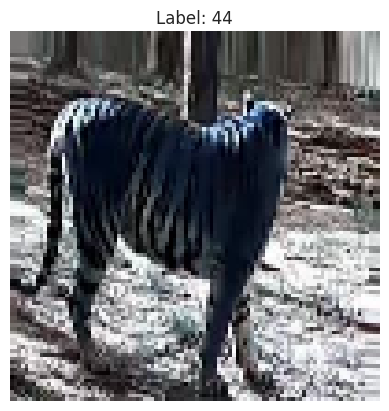

Building the CNN model...
Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 100, 100, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 100, 100, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 50, 50, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 50, 16)     │             64 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 50, 50, 32)     │          4,640 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 50, 50, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 50, 50, 32)     │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 50, 50, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 25, 25, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 25, 25, 32)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 25, 25, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 25, 25, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 25, 25, 64)     │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 25, 25, 64)     │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 12, 12, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 2,460,475 (9.39 MB)

 Trainable params: 2,459,803 (9.38 MB)

 Non-trainable params: 672 (2.62 KB)

Compiling model...
Setting up learning rate scheduler...
Applying image data augmentation...
Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.3424 - loss: 2.9032 - val_accuracy: 0.0136 - val_loss: 9.9204 - learning_rate: 0.0010
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.8592 - loss: 0.5866 - val_accuracy: 0.0224 - val_loss: 10.9748 - learning_rate: 0.0010
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.9225 - loss: 0.3065 - val_accuracy: 0.2780 - val_loss: 3.6409 - learning_rate: 0.0010
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - accuracy: 0.9565 - loss: 0.1858 - val_accuracy: 0.7374 - val_loss: 0.8430 - learning_rate: 0.0010
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.9602 - loss: 0.1601 - val_accuracy: 0.8963 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.9697 - loss: 0.1160 - val_accuracy: 0.8033 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.

In [ ]:
# ====================================
# Setup: Check GPU + Installations
# ====================================
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Optional: Force GPU use or set memory growth
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)



# ====================================
# Imports
# ====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Add
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ====================================
# Load your DataFrame
# ====================================
# If you've exported train_df to CSV earlier, load it:
# train_df = pd.read_csv("/content/drive/MyDrive/path/to/train_df.csv")

# OR, if already defined:
# from wherever your 'train_df' is defined
# Ensure train_df['filepaths'] has paths accessible from Colab

# ====================================
# Step 1: Split the dataset
# ====================================
print("Splitting the dataset into training and validation sets...")
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['labels'],
    random_state=42
)

# ====================================
# Step 2: Image Preprocessing Function
# ====================================
def load_and_preprocess_images(df, image_size=(100, 100)):
    print(f"Loading and preprocessing {len(df)} images...")
    images = []
    for idx, path in enumerate(df['filepaths']):
        if idx % 500 == 0:
            print(f"Processed {idx}/{len(df)} images...")
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Failed to load image {path}")
            continue
        img = cv2.resize(img, image_size)
        images.append(img)
    print("Image loading complete.")
    return np.array(images)

# ====================================
# Step 3: Load X and Y
# ====================================
print("Loading training images...")
x_train = load_and_preprocess_images(train_data) / 255.0

print("Loading validation images...")
x_val = load_and_preprocess_images(val_data) / 255.0

y_train = train_data['labels'].values
y_val = val_data['labels'].values

print("Shapes — x_train:", x_train.shape, "x_val:", x_val.shape)

# ====================================
# Step 4: Encode and One-Hot Labels
# ====================================
print("Encoding and one-hot encoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

NUM_CLASSES = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)

print("Label encoding complete. Number of classes:", NUM_CLASSES)

# ====================================
# Step 5: Visual Check
# ====================================
print("Showing one sample image from the training set...")
plt.imshow(x_train[0])
plt.title("Label: " + str(np.argmax(y_train[0])))
plt.axis("off")
plt.show()

# ====================================
# Step 6: CNN Model
# ====================================
print("Building the CNN model...")
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Add, Activation

input_layer = Input(shape=(100, 100, 3))

# Block 1
x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
x = MaxPool2D((2, 2))(x)
x = BatchNormalization()(x)

# Block 2 with skip connection
x1 = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x2 = Conv2D(32, (3, 3), padding='same')(x1)
x2 = Add()([x1, x2])
x2 = Activation('relu')(x2)
x2 = MaxPool2D((2, 2))(x2)
x2 = Dropout(0.25)(x2)

# Block 3 with skip connection
x3 = Conv2D(64, (3, 3), padding='same', activation='relu')(x2)
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = Add()([x3, x4])
x4 = Activation('relu')(x4)
x4 = MaxPool2D((2, 2))(x4)
x4 = BatchNormalization()(x4)

# Dense Layers
x4 = Flatten()(x4)
x4 = Dense(256, activation='relu')(x4)
x4 = BatchNormalization()(x4)
output = Dense(NUM_CLASSES, activation='softmax')(x4)

model = Model(inputs=input_layer, outputs=output)


print("Model summary:")
model.summary()

# ====================================
# Step 7: Compile
# ====================================
print("Compiling model...")
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ====================================
# Step 8: Learning Rate Scheduler
# ====================================
print("Setting up learning rate scheduler...")
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=1e-6)

# ====================================
# Step 9: Data Augmentation
# ====================================
print("Applying image data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# ====================================
# Step 10: Train the Model
# ====================================
print("Starting model training...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[lr_reduction]
)
print("Training complete!")


Num GPUs Available:  1
Splitting the dataset into training and validation sets...
Loading training images...
Loading and preprocessing 8560 images...
Processed 0/8560 images...
Processed 500/8560 images...
Processed 1000/8560 images...
Processed 1500/8560 images...
Processed 2000/8560 images...
Processed 2500/8560 images...
Processed 3000/8560 images...
Processed 3500/8560 images...
Processed 4000/8560 images...
Processed 4500/8560 images...
Processed 5000/8560 images...
Processed 5500/8560 images...
Processed 6000/8560 images...
Processed 6500/8560 images...
Processed 7000/8560 images...
Processed 7500/8560 images...
Processed 8000/8560 images...
Processed 8500/8560 images...
Image loading complete.
Loading validation images...
Loading and preprocessing 2140 images...
Processed 0/2140 images...
Processed 500/2140 images...
Processed 1000/2140 images...
Processed 1500/2140 images...
Processed 2000/2140 images...
Image loading complete.
Shapes — x_train: (8560, 100, 100, 3) x_val: (2140

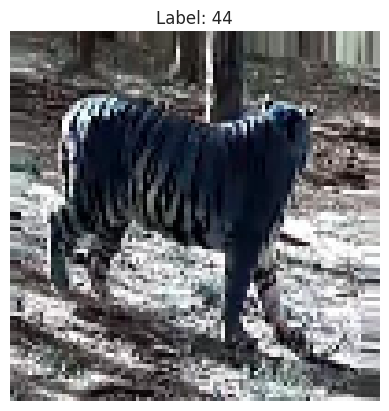

Building the CNN model...
Building the improved CNN model...
Model summary:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 100, 100, 16)   │            448 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 100, 100, 16)   │          2,320 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 50, 50, 16)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 50, 50, 16)     │             64 │ max_pooling2d_9[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 50, 50, 16)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 50, 50, 32)     │          4,640 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 50, 50, 32)     │          9,248 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 50, 50, 32)     │              0 │ conv2d_24[0][0],       │
│                           │                        │                │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 50, 50, 32)     │              0 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 25, 25, 32)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 25, 25, 32)     │            128 │ max_pooling2d_10[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 25, 25, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 25, 25, 64)     │         18,496 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 25, 25, 64)     │         36,928 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 25, 25, 64)     │              0 │ conv2d_26[0][0],       │
│                           │                        │                │ conv2d_27[0][0]        │
├──────────────────────

 Total params: 2,711,227 (10.34 MB)

 Trainable params: 2,709,723 (10.34 MB)

 Non-trainable params: 1,504 (5.88 KB)

Compiling model...
Setting up learning rate scheduler...
Applying image data augmentation...
Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 261ms/step - accuracy: 0.1752 - loss: 4.0096 - val_accuracy: 0.0187 - val_loss: 9.9863 - learning_rate: 0.0010
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.6330 - loss: 1.4122 - val_accuracy: 0.0379 - val_loss: 9.5071 - learning_rate: 0.0010
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.7906 - loss: 0.8697 - val_accuracy: 0.1210 - val_loss: 7.8380 - learning_rate: 0.0010
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.8472 - loss: 0.6839 - val_accuracy: 0.5692 - val_loss: 1.8804 - learning_rate: 0.0010
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.8645 - loss: 0.6144 - val_accuracy: 0.9033 - val_loss: 0.5185 - learning_rate: 0.0010
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.8898 - loss: 0.5473 - val_accuracy: 0.8028 - val_loss: 0.8552 - learning_rate: 0.0010
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.9

In [ ]:
# ====================================
# Setup: Check GPU + Installations
# ====================================
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Optional: Force GPU use or set memory growth
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)



# ====================================
# Imports
# ====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Add
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ====================================
# Load your DataFrame
# ====================================
# If you've exported train_df to CSV earlier, load it:
# train_df = pd.read_csv("/content/drive/MyDrive/path/to/train_df.csv")

# OR, if already defined:
# from wherever your 'train_df' is defined
# Ensure train_df['filepaths'] has paths accessible from Colab

# ====================================
# Step 1: Split the dataset
# ====================================
print("Splitting the dataset into training and validation sets...")
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['labels'],
    random_state=42
)

# ====================================
# Step 2: Image Preprocessing Function
# ====================================
def load_and_preprocess_images(df, image_size=(100, 100)):
    print(f"Loading and preprocessing {len(df)} images...")
    images = []
    for idx, path in enumerate(df['filepaths']):
        if idx % 500 == 0:
            print(f"Processed {idx}/{len(df)} images...")
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Failed to load image {path}")
            continue
        img = cv2.resize(img, image_size)
        images.append(img)
    print("Image loading complete.")
    return np.array(images)

# ====================================
# Step 3: Load X and Y
# ====================================
print("Loading training images...")
x_train = load_and_preprocess_images(train_data) / 255.0

print("Loading validation images...")
x_val = load_and_preprocess_images(val_data) / 255.0

y_train = train_data['labels'].values
y_val = val_data['labels'].values

print("Shapes — x_train:", x_train.shape, "x_val:", x_val.shape)

# ====================================
# Step 4: Encode and One-Hot Labels
# ====================================
print("Encoding and one-hot encoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

NUM_CLASSES = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val = to_categorical(y_val, num_classes=NUM_CLASSES)

print("Label encoding complete. Number of classes:", NUM_CLASSES)

# ====================================
# Step 5: Visual Check
# ====================================
print("Showing one sample image from the training set...")
plt.imshow(x_train[0])
plt.title("Label: " + str(np.argmax(y_train[0])))
plt.axis("off")
plt.show()

# ====================================
# Step 6: CNN Model
# ====================================
print("Building the CNN model...")
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Add, Activation
from tensorflow.keras.regularizers import l2

print("Building the improved CNN model...")
input_layer = Input(shape=(100, 100, 3))

# Block 1
x = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(input_layer)
x = Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
x = MaxPool2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Block 2 with skip connection
x1 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
x2 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x1)
x2 = Add()([x1, x2])
x2 = Activation('relu')(x2)
x2 = MaxPool2D((2, 2))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)

# Block 3 with skip connection
x3 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x2)
x4 = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x3)
x4 = Add()([x3, x4])
x4 = Activation('relu')(x4)
x4 = MaxPool2D((2, 2))(x4)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.3)(x4)

# Block 4 with skip connection (extra!)
x5 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x4)
x6 = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x5)
x6 = Add()([x5, x6])
x6 = Activation('relu')(x6)
x6 = MaxPool2D((2, 2))(x6)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.4)(x6)

# Dense Layers
x6 = Flatten()(x6)
x6 = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x6)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.5)(x6)

output = Dense(NUM_CLASSES, activation='softmax')(x6)

model = Model(inputs=input_layer, outputs=output)


print("Model summary:")
model.summary()

# ====================================
# Step 7: Compile
# ====================================
print("Compiling model...")
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ====================================
# Step 8: Learning Rate Scheduler
# ====================================
print("Setting up learning rate scheduler...")
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=1e-6)

# ====================================
# Step 9: Data Augmentation
# ====================================
print("Applying image data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# ====================================
# Step 10: Train the Model
# ====================================
print("Starting model training...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[lr_reduction]
)
print("Training complete!")


In [ ]:
# Save the model
model.save('cnn_model_97.keras')


In [ ]:
def load_and_preprocess_images(df, image_size=(100, 100)):
    print(f"Loading and preprocessing {len(df)} images...")
    images = []
    for idx, path in enumerate(df['filepaths']):
        if idx % 500 == 0:
            print(f"Processed {idx}/{len(df)} images...")
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Failed to load image {path}")
            continue
        img = cv2.resize(img, image_size)
        images.append(img)
    return np.array(images)


In [ ]:
x_test = load_and_preprocess_images(test_df) / 255.0
y_test = label_encoder.transform(test_df['labels'])
y_test = to_categorical(y_test, num_classes=len(label_encoder.classes_))


Loading and preprocessing 189 images...
Processed 0/189 images...


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.9599 - loss: 0.1474
Test Accuracy: 96.83%
Test Loss: 0.1477


In [ ]:
# Predict the labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert softmax outputs to label indices

# Also make sure y_test is in label form (not one-hot)
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Now get the report
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


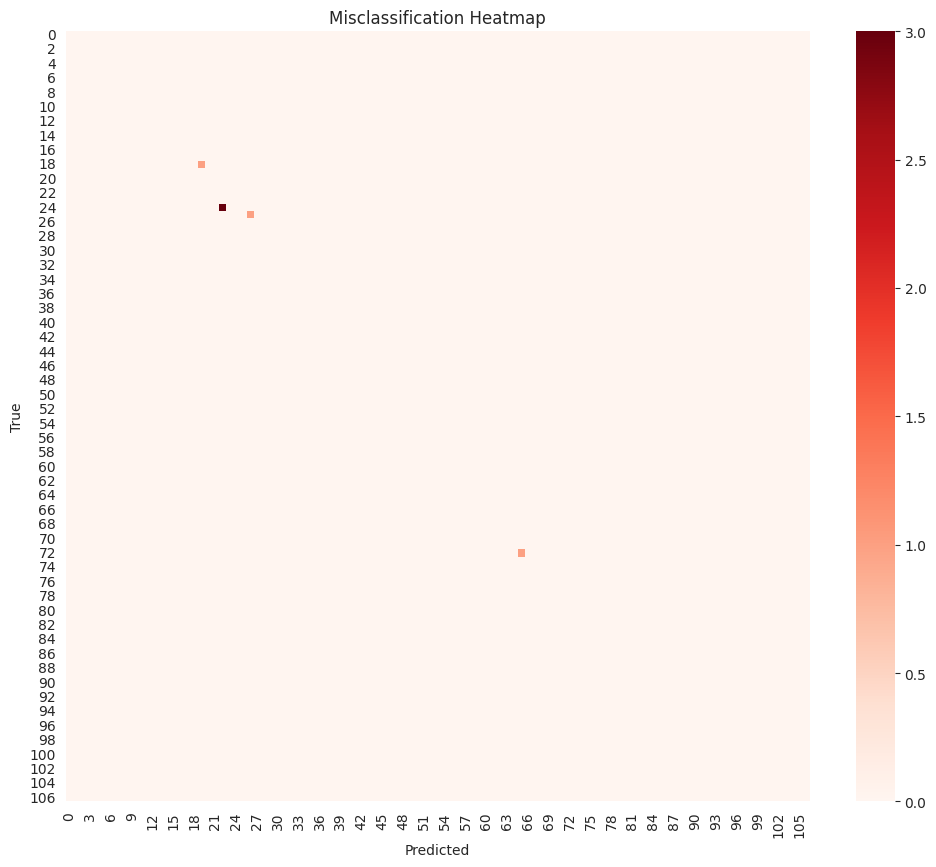

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf = confusion_matrix(y_test_labels, y_pred)
conf_errors = conf.copy()
np.fill_diagonal(conf_errors, 0)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_errors, cmap='Reds')
plt.title("Misclassification Heatmap")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

# Pick a random image
random_row = test_df.sample(n=1, random_state=42).iloc[0]
image_path = random_row['filepaths']
label = random_row['labels']

# Load original image
original_img = cv2.imread(image_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize and normalize image (same as used in your preprocessing)
processed_img = cv2.resize(original_img, (100, 100),interpolation=cv2.INTER_AREA)
processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
processed_img_normalized = processed_img_rgb / 255.0


processed_img2 = resize_with_padding(original_img)
processed_img_rgb2 = cv2.cvtColor(processed_img2, cv2.COLOR_BGR2RGB)
processed_img_normalized2 = processed_img_rgb / 255.0


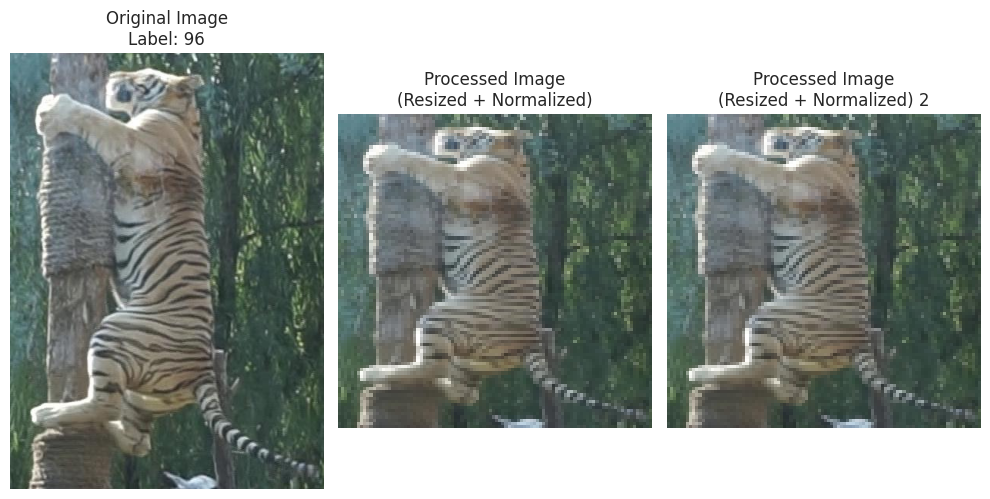

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Original image
ax[0].imshow(original_img_rgb)
ax[0].set_title(f"Original Image\nLabel: {label}")
ax[0].axis('off')

# Processed image
ax[1].imshow(processed_img_normalized)
ax[1].set_title("Processed Image\n(Resized + Normalized)")
ax[1].axis('off')

ax[2].imshow(processed_img_normalized2)
ax[2].set_title("Processed Image\n(Resized + Normalized) 2")
ax[2].axis('off')

plt.tight_layout()
plt.show()


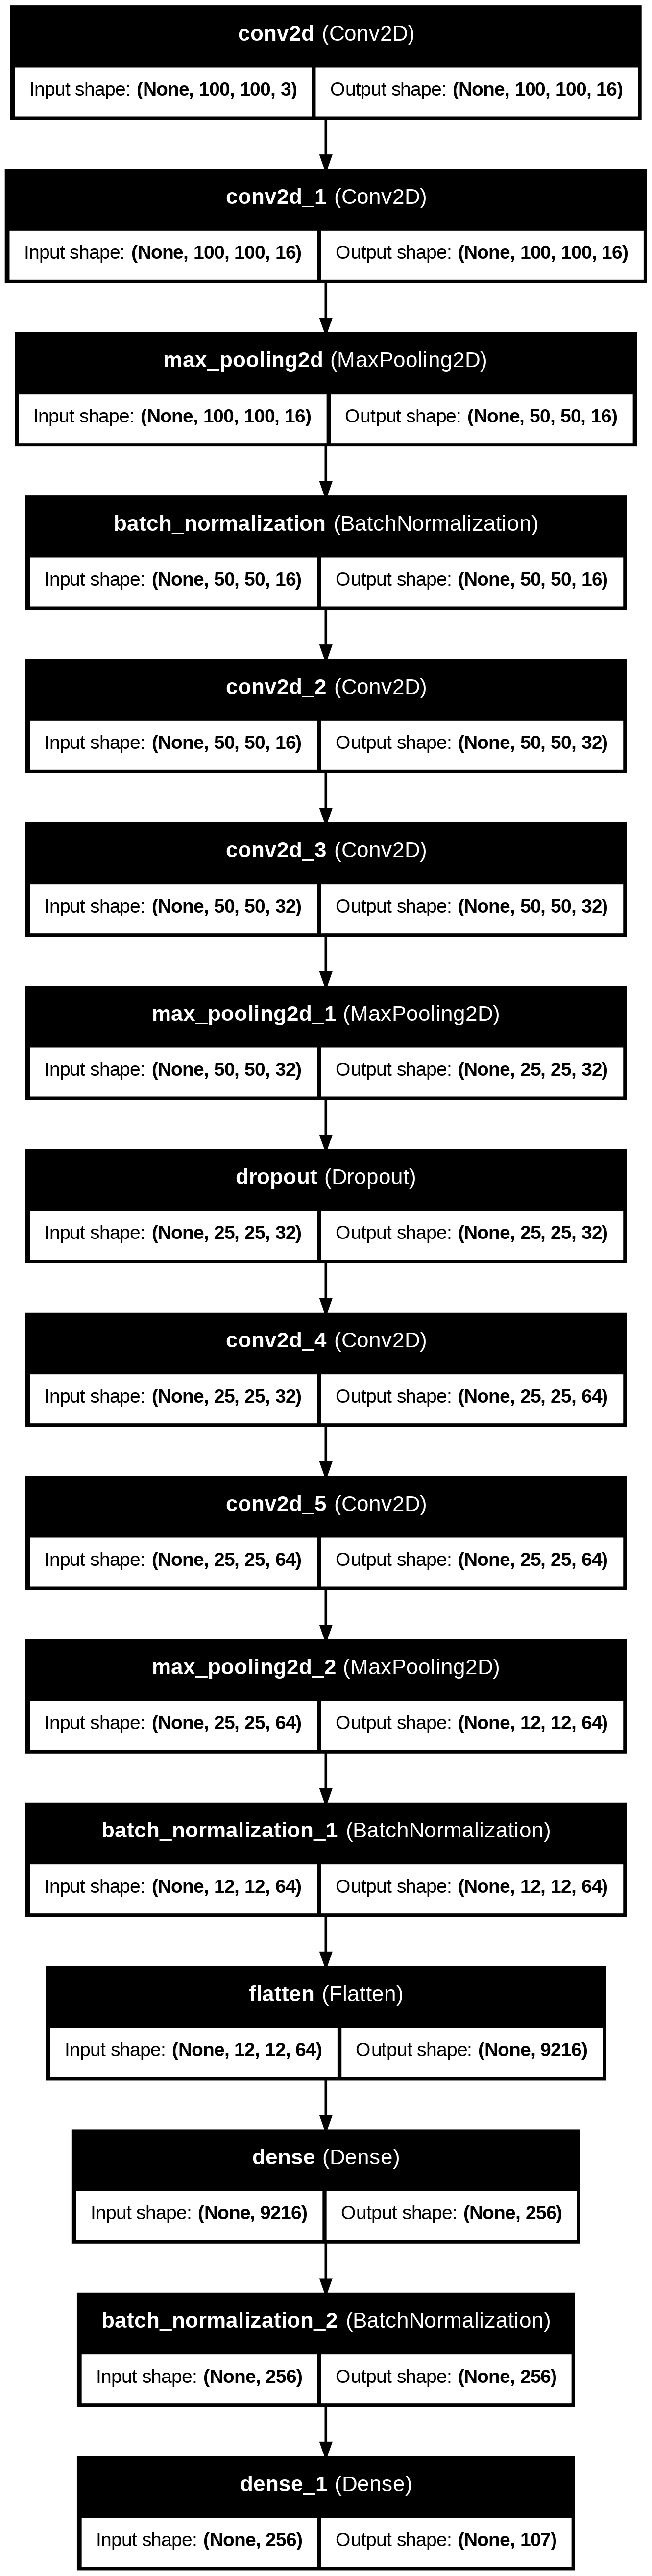

In [ ]:
from tensorflow.keras.utils import plot_model

# Save model architecture plot
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display it in notebook
from IPython.display import Image
Image(filename='model_architecture.png')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 53.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


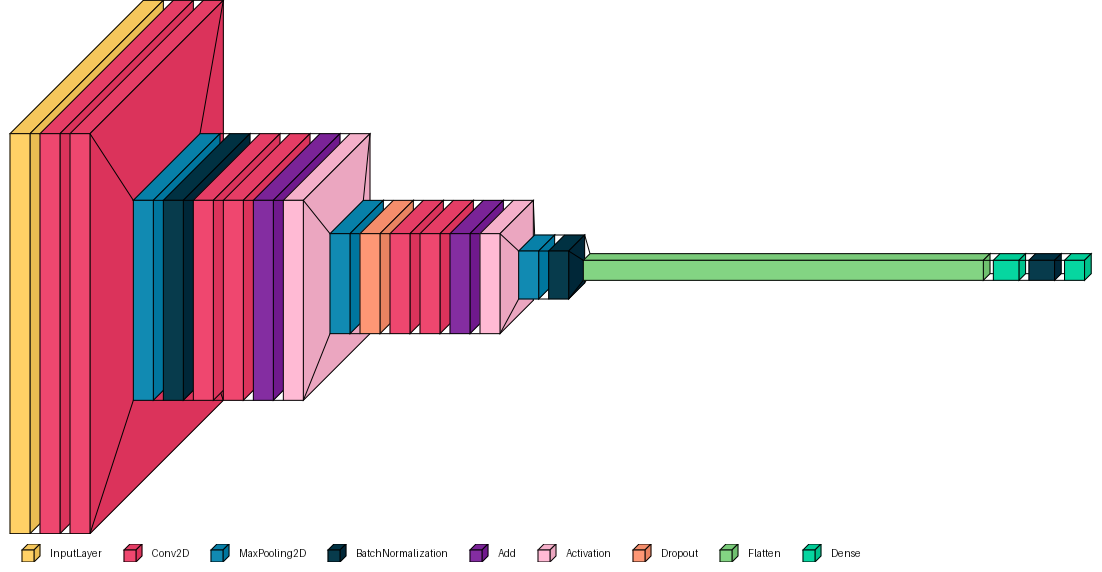

In [ ]:
!pip install visualkeras

import visualkeras
from PIL import ImageFont

# Optional: add a nicer font
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = None

# Draw the model
visualkeras.layered_view(model, legend=True, font=font)


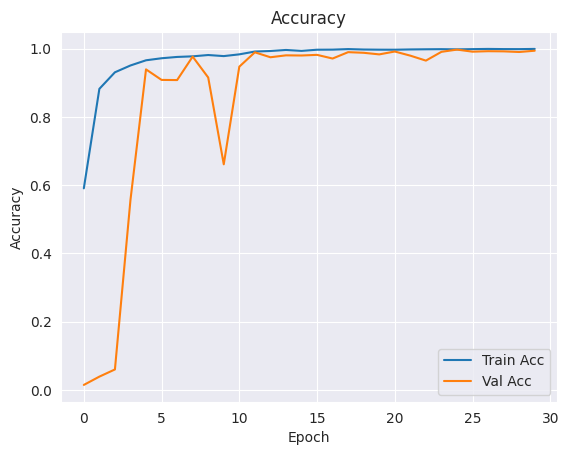

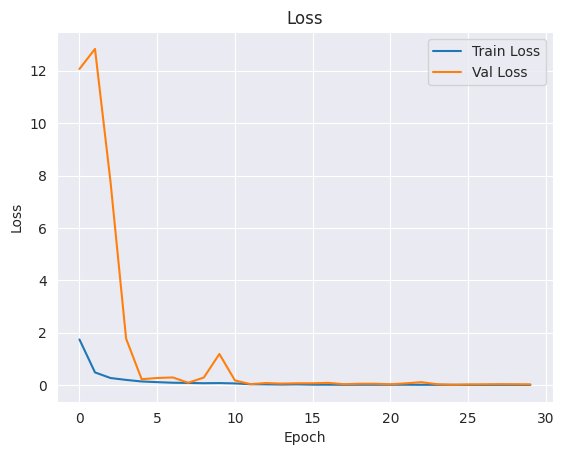

In [ ]:
# Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Generating predictions on validation set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Total misclassified images: 6


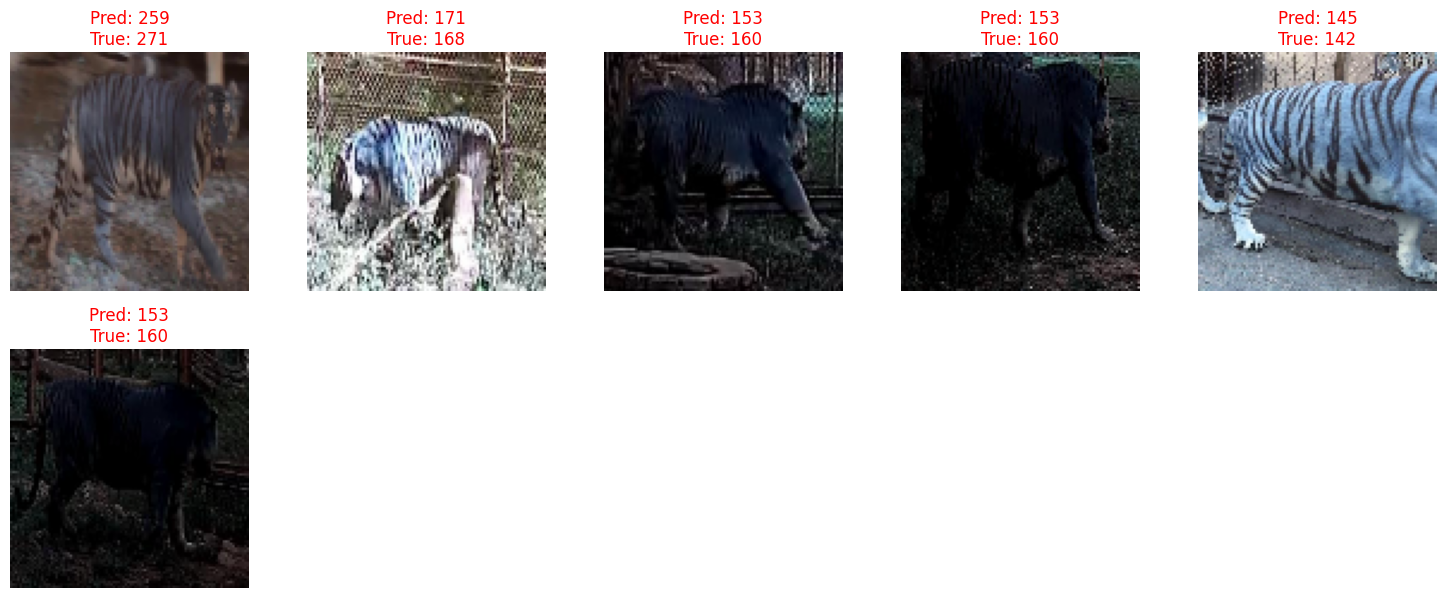

In [ ]:
import matplotlib.pyplot as plt

def show_misclassified_images(x_val, y_val, model, label_encoder, num_images=25):
    print("Generating predictions on validation set...")
    y_pred_probs = model.predict(x_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    misclassified_idxs = np.where(y_pred != y_true)[0]
    print(f"Total misclassified images: {len(misclassified_idxs)}")

    if len(misclassified_idxs) == 0:
        print("No misclassified images!")
        return

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(misclassified_idxs[:num_images]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_val[idx])
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to visualize
show_misclassified_images(x_test, y_test, model, label_encoder, num_images=25)


In [ ]:
len(test_df)

189